# Understanding Our Data

The [dataset](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge/dataset_files) that we have chosen to use consists of a million different Spotify playlists. In total, the original zip file of this dataset is 5.39 GB large... we are working with a whole lot of data! For this reason, we want to find an appropriate minimum follower threshold that can be used to filter our data. For example, we might want to exclude all playlists with a single follower... how would this effect the total amount of playlists we will be analyzing? How drastic is the change from considering playlists with more than 2 followers verses more than 10 followers? What is a realistic value for a minimum follower threshold that results in a manageable dataset to extract meaningful results?

Firstly, let's import any libraries needed for code in this notebook.

In [10]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import numpy as np
import prettytable as pt

## What is the frequency of playlists that have 1 follower?

Data about different playlists is stored in 1,000 different JSON files. Each JSON files contains data about 100,000 playlists.

We create a function that, given the path to a single one of these JSON files, returns a dictionary containing the number of followers and the frequency of playlists with this count. That is, a dictionary `{1:2, 3:4}` signifies that there exist 2 playlists with 1 follower and 4 playlists with 3 followers in the given JSON file.

In [11]:
def get_frequency_from_json(json_file_path):
    frequency = {}

    data = json.load(open(json_file_path, 'r'))
    playlists = data["playlists"]

    for playlist in playlists:
        followers = playlist["num_followers"]
        frequency[followers] = frequency.get(followers, 0) + 1
    return frequency

Now, we can use our function to construct a dictionary with information about the frequency of different numbers of followers for all JSON files.

In [12]:
path = os.path.join("..", "data", "raw")

frequency = {}

for filename in os.listdir(path):
    if filename.endswith('json'):
        for key, value in get_frequency_from_json(os.path.join(path, filename)).items():
            frequency[key] = frequency.get(key, 0) + value

Next, we can create a dataframe from our frequency dictionary for a better visualization of our data.

In [13]:
df = pd.DataFrame(data=list(frequency.items()), columns=["Number of followers", "Frequency"])
df = df.sort_values(by="Number of followers", ascending=True)
df = df.set_index("Number of followers")

display(df.T)

Number of followers,1,2,3,4,5,6,7,8,9,10,...,758,914,1038,1041,1559,2699,2994,6568,14812,15842
Frequency,37696,7416,2409,1039,492,282,153,110,71,47,...,1,1,1,1,1,1,1,1,1,1


We can represent the frequency data as a bar plot to observe if there are any clear trends. From the plot below, we observe that there the "step" sizes between playlists that have a difference of 1 follower seem to be rather consistent on the lower end of follower counts.

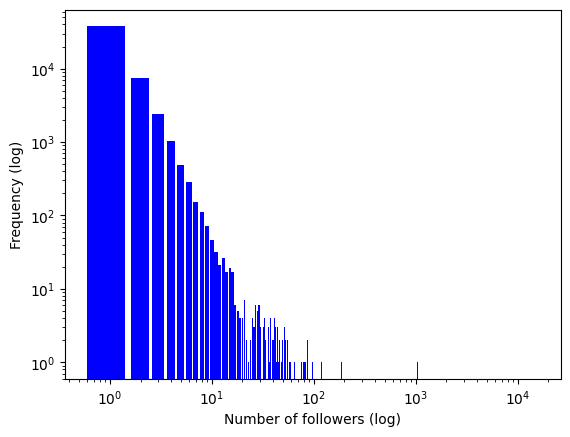

In [14]:
plt.bar(list(frequency.keys()), list(frequency.values()), color='blue')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of followers (log)')
plt.ylabel('Frequency (log)')
plt.show()

## How is our data spread out? What if we ignore all playlists with 1 follower?

We now see that there are clearly more playlists with a lower number of followers, but how exactly is our frequency data spread out?

We can use different descriptive statistics to better understand the spread of our data. For this, we create a function that, given an input of how many minimum followers should be considered, prints a table with an overview of descriptive statistics. This provides a clear way to compare the effects of considering playlists with a minimum of 1 followers versus a minimum of 10 followers.

In [19]:
dataset = sorted([key for key, value in frequency.items() for _ in range(value)])

def data_spread(threshold: int = 1):
    subset = [value for value in dataset if value >= threshold]

    print("Considering all playlists with at least {} follower(s)".format(threshold))
    print("Number of playlists considered:", len(subset))
    table = pt.PrettyTable()
    table.field_names = ["Statistic", "Value"]
    table.add_row(["Mean", np.mean(subset)])
    table.add_row(["Median", np.median(subset)])
    table.add_row(["Standard deviation", np.std(subset)])
    table.add_row(["Variance", np.var(subset)])
    table.add_row(["Quartiles", [quartile for quartile in np.percentile(subset,[25,50,75])]])
    print(table, "\n")

We use this function to play around with how the minimum follower threshold effects the spread of our data.

It doesn't make much sense to include playlists with only 1 follower in our analysis as this implies the playlist's creator is following their own playlist and nobody else. What if we only consider playlists with more than 1 follower? What about 10 followers? How does this effect the spread of our data as well as the amount of data we are working with?

In [20]:
data_spread(1)
data_spread(2)
data_spread(10)

Considering all playlists with at least 1 follower(s)
Number of playlists considered: 50000
+--------------------+--------------------+
|     Statistic      |       Value        |
+--------------------+--------------------+
|        Mean        |      2.62358       |
|       Median       |        1.0         |
| Standard deviation | 103.6822222369081  |
|      Variance      | 10750.003207983602 |
|     Quartiles      |  [1.0, 1.0, 1.0]   |
+--------------------+--------------------+ 

Considering all playlists with at least 2 follower(s)
Number of playlists considered: 12304
+--------------------+--------------------+
|     Statistic      |       Value        |
+--------------------+--------------------+
|        Mean        | 7.5977730819245775 |
|       Median       |        2.0         |
| Standard deviation | 208.93102912988368 |
|      Variance      | 43652.174933272305 |
|     Quartiles      |  [2.0, 2.0, 3.0]   |
+--------------------+--------------------+ 

Considering all play

Now, it's not very efficient to be comparing how specific changes in the minimum threshold effect our data. Instead, we can create a dataframe that gives us a more complete overview of how changing the threshold of minimum followers affects the spread of our data.

In [21]:
spread_df = pd.DataFrame(columns=["Min followers", "Num of playlists", "Mean", "Median", "Stdev", "Variance", "Quartiles"])

while dataset:
    spread_df.loc[len(spread_df.index)] = [dataset[0], 
                                           len(dataset), 
                                           np.mean(dataset), 
                                           np.median(dataset),
                                           np.std(dataset),
                                           np.var(dataset),
                                           [quartile for quartile in np.percentile(dataset,[25,50,75])]]

    dataset = [value for value in dataset if value != dataset[0]]

display(spread_df)

,Min followers,Num of playlists,Mean,Median,Stdev,Variance,Quartiles
0,1,50000,2.623580,1.0,103.682222,1.075000e+04,"[1.0, 1.0, 1.0]"
1,2,12304,7.597773,2.0,208.931029,4.365217e+04,"[2.0, 2.0, 3.0]"
2,3,4888,16.090630,4.0,331.301868,1.097609e+05,"[3.0, 4.0, 5.0]"
3,4,2479,28.811618,5.0,464.859297,2.160942e+05,"[4.0, 5.0, 7.0]"
4,5,1440,46.713889,6.0,609.300774,3.712474e+05,"[5.0, 6.0, 9.0]"
...,...,...,...,...,...,...,...
93,2699,5,8583.000000,6568.0,5681.762473,3.228242e+07,"[2994.0, 6568.0, 14812.0]"
94,2994,4,10054.000000,10690.0,5434.503289,2.953383e+07,"[5674.5, 10690.0, 15069.5]"
95,6568,3,12407.333333,14812.0,4150.388362,1.722572e+07,"[10690.0, 14812.0, 15327.0]"
96,14812,2,15327.000000,15327.0,515.000000,2.652250e+05,"[15069.5, 15327.0, 15584.5]"
